# TR Data Challenge
This task is to train a model that, given a sentence, predicts the correct author of the sentence (either Austen or Bronte). It can be regarded as a typical binary classification problem. I can use NLP technics to transfer sentences into vectors and training a classifier to distinguish two classes.

* **Data preprocessing**

This procedure includes tokenization, lowercase converting, removing stopping words, verb lemmatization and so on.

* **Data exploration**

There are two authors in the provided dataset: Austen with 16k sentences in 3 documents and Bronte with 13K sentences in 2 documents. Although data is slightly unbalanced, it may not cause any serious problem since they are very close.

After the data preprocessing, there are 8K and 12K vocabulary Austen and Bronte, respectively.

* **Evaluation metrics**

The evaluation methods include accuracy, AUC and F1 score.

* **Encoding methods**

Three embedding methods including label encoder, Bag of Word and TF-IDF are deployed. The performances of these methods on different models are shown in the following sections. 

* **Model selection**

One traditional machine learning model and two deep learning models are selected.

(1) **Naive Bayes**: It is a traditional machine learning classifier. 

(2) **Bidirectional LSTM**: This neural network model is able to almost seamlessly model problems with multiple input variables and provides benefits in sequence data classification comparing to classical Naive Bayes model which can be difficult to include the sequential feature of the input sentence. 

(3) **Convolution Bi-LSTM**: CNNs excel at learning the spatial structure of the input data. The learned spatial features may then be learned as sequences by the LSTM layers. A convoluation layer and a pooling layer are added between the embedding and LSTM layers.

* **Comparison**

All of these three word encoding methods are applied in Naive Bayesian approach (NB_LE, NB_BW, NB_TF) and only LabelEncoder is used for deep learning methods (BiLSTM_LE, C_BiLSTM) due to time limitation. The evaluation metrics include accuracy, AUC and F1 score.

|          | NB_LE  | NB_BW  | NB_TF  | BiLSTM_LE | C_BILSTM_LE |
| -------- | ------ | ------ | ------ | --------- | ----------- |
| Acc      | 0.4665 | 0.7749 | 0.7746 | 0.8525    | 0.8623      |
| AUC      | 0.5037 | 0.8813 | 0.8815 | 0.9477    | 0.9452      |
| F1 Score | 0.2110 | 0.8038 | 0.8098 | 0.8761    | 0.8779      |


* **Summary**

 * TF-IDF gives better results than others in overall as it reveals more information and reflects how important a word in the document.
 * BiLSTM performs similar to convolutional BiLSTM but the running time of the latter one is much shorter.
 * Neural network methods perform better than Naive bayes with same inputs but more scenarios should be investigated.

* **Future work**
 * Due to the time limitation, only Label Encoder method is applied for the two deep learning approaches but it already shows fairly good results. Two other encoding methods should be tried in the future.
 * More complex structure on deep neural network model may be considered such as adding attention layers.
 * The variety of patterns in data preparation should be included such as identifying the grammatical group of the words.

* **Reference**

 * Ding et al. (2019) "Learning Stylometric Representations for Authorship Analysis", IEEE Transactions on Cybernetics, 49(1), 107-121. 

 * Kim et al. (2011) "Literary Style Classification with Deep Linguistic Analysis Features", https://pdfs.semanticscholar.org/19f2/63c908b6b087c9ae30241de7a3209fabe649.pdf.

 * Brownlee. (2016) "Sequence Classification with LSTM Recurrent Neural Networks in Python with Keras", https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

# Please download related corpus by "import nltk; nltk.download()" to the run the script.

# Packages 

The major packages related to this project are keras, nltk and sklearn.

In [48]:
import glob
import matplotlib.pyplot as plt
from os.path import normpath, basename, join
from nltk import tokenize
from nltk.corpus import stopwords 
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from collections import defaultdict
import bisect
import matplotlib.pyplot as plt
from yellowbrick.text import TSNEVisualizer
import unicodedata, re, inflect
import regex
import time
import pandas as pd
import numpy as np
import itertools
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Bidirectional, LSTM, Embedding
from keras.preprocessing import sequence
from keras.optimizers import Adam
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras import regularizers
from keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# Data Preprocessing

The data preprocessing pipeline is built as below:

Tokenization:
Tokenization is the first step in text analytics. The process of breaking down a text paragraph into smaller chunks such as words or sentence is called Tokenization.

Converting words to their lower cases:
All the capital letters are converted to their lower cases.

Removing punctuation:
Remove punctuations such as '?','!','.'.

Converting numbers to their word equivalents:
Convert the Arabic numbers to English. ie. '123' to 'one hundred and twenty-three'.

Remove stopping words:
Stopwords are considered as noises in the text. Text may contain stop words such as is, am, are, this, a, an, the, etc. Using NLTK corpus of stopwords, a list of stopwords is created to filter out the unnecessary tokenized words.

Lemmatization:
Lemmatization reduces words to their base word, which is linguistically correct lemmas. It transforms root word with the use of vocabulary and morphological analysis.

In [38]:
# functions for data preprocessing

def word_split(sentence, pattern=r'\p{L}+\p{P}?\p{L}+'):
    compiled_pattern = regex.compile(pattern)
    tokenized_sentence = compiled_pattern.finditer(sentence)
    for match in tokenized_sentence:
        yield match.group()

def text_preprocessing(author_directory):
    author_name = basename(normpath(author_directory))
    sentence_list = []
    for book_path in glob.glob(join(author_directory,'*.txt')):
        with open(book_path) as f:
            lines = f.read()
        f.close()
        text = lines.lower().split("\n\n")
        text = [tokenize.sent_tokenize(a.replace('\n',' ')) for a in text]
        text = list(itertools.chain(*text))
        book_name = basename(book_path).split('.')[0]
        cut_sign = f'project gutenberg ebook {book_name}'
        sentence = []
        indx = []
        for x in text:
            if (len(list(word_split(x)))>5)&(author_name not in x):
                sentence.append(x)
        for y in sentence:
            if (cut_sign in y):
                indx.append(sentence.index(y))
        sentence_list += sentence[(indx[0]+1):(indx[1])]
    dict={'Sentence':sentence_list,'Author':author_name}
    df = pd.DataFrame(dict)
    return df

In [37]:
austen_directory = './gutenberg/austen/'
bronte_directory = './gutenberg/bronte/'
df_austen = text_preprocessing(austen_directory)
df_bronte = text_preprocessing(bronte_directory)
df = pd.concat([df_austen,df_bronte],ignore_index=True)
df.head()

,Sentence,Author
0,special thanks are due to sharon partridge for...,austen
1,the family of dashwood had long been settled ...,austen
2,"their estate was large, and their residence wa...",austen
3,the late owner of this estate was a single man...,austen
4,"but her death, which happened ten years before...",austen


In [39]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words = lemmatize_verbs(words)
    return words

The tokenized and normalized sentences are added to the dataframe as the column 'Token'.

In [40]:
token = []
for i in df['Sentence']:
    word_tokens = list(word_split(i))
    token.append(normalize(word_tokens))
df.insert(1, "Token", token)
df.head()

,Sentence,Token,Author
0,special thanks are due to sharon partridge for...,"[special, thank, due, sharon, partridge, exten...",austen
1,the family of dashwood had long been settled ...,"[family, dashwood, long, settle, sussex]",austen
2,"their estate was large, and their residence wa...","[estate, large, residence, norland, park, cent...",austen
3,the late owner of this estate was a single man...,"[late, owner, estate, single, man, live, advan...",austen
4,"but her death, which happened ten years before...","[death, happen, ten, years, produce, great, al...",austen


# Data Exploration

The most two frequent words are 'say' and 'mr' in Austen's books and 'say' and 'would' in Bronte's books. Although these words are common, they are not included in the nltk stopwords corpus. These words might be the author's personal stylometry.

Number of sentences in Austen dataset: 15925
Vocab length for Austen: 7951
<FreqDist with 7951 samples and 176899 outcomes>
Most 2 common words for Austen: [('say', 2043), ('mr', 2028)]


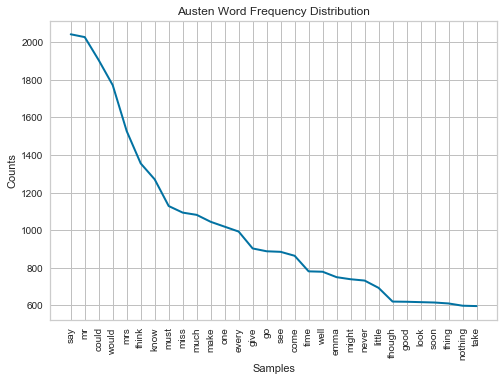

In [41]:
processed_words_a = list(df[df.Author=='austen']['Token'].apply(pd.Series).stack())
fdist_a = FreqDist(processed_words_a)
print('Number of sentences in Austen dataset:',len(df_austen['Sentence']))
print('Vocab length for Austen:',len(set(processed_words_a)))
print(fdist_a)
print('Most 2 common words for Austen:', fdist_a.most_common(2))
plt.clf()
plt.title('Austen Word Frequency Distribution')
fdist_a.plot(30,cumulative=False)
plt.show()

Number of sentences in Bronte dataset: 13092
Vocab length for Bronte: 12089
<FreqDist with 12089 samples and 136999 outcomes>
Most 2 common words for Austen: [('say', 1215), ('would', 1084)]


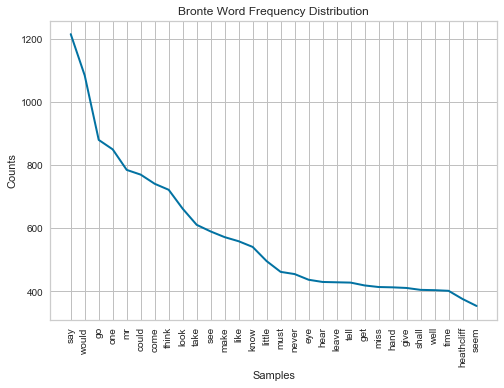

In [42]:
processed_words_b = list(df[df.Author=='bronte']['Token'].apply(pd.Series).stack())
fdist_b = FreqDist(processed_words_b)
print('Number of sentences in Bronte dataset:',len(df_bronte['Sentence']))
print('Vocab length for Bronte:',len(set(processed_words_b)))
print(fdist_b)
print('Most 2 common words for Austen:', fdist_b.most_common(2))
plt.clf()
plt.title('Bronte Word Frequency Distribution')
fdist_b.plot(30,cumulative=False)
plt.show()

# Evaluation Metrics

Since it is a binary classification problem, Accuracy, AUC and F1 score are used as the evaluation metrics.

Accuracy (Acc): Percentage of total items classified correctly.

AUC: The probabilistic interpretation of ROC-AUC score is that if you randomly choose a positive case and a negative case, the probability that the positive case outranks the negative case according to the classifier is given by the AUC.

F1 score: It is a harmonic mean of precision and recall so it can keep a balance between Precision and Recall.

# Embedding methods

Label encoder, bag of words and TF-IDF are considered.

**Label Encoder:** Identify each word as a unique number.

**Bag of words (BOW):** Bag of Words is an algorithm that counts how many times a word appears in a document.

**TF-IDF:** With TF-IDF, words are given weight – TF-IDF measures relevance, not frequency. That is, word counts are replaced with TF-IDF scores across the whole dataset.

In Term Frequency(TF), you just count the number of words occurred in each document. The main issue with this Term Frequency is that it will give more weight to longer documents. Term frequency is basically the output of the BoW model.

IDF(Inverse Document Frequency) measures the amount of information a given word provides across the document. IDF is the logarithmically scaled inverse ratio of the number of documents that contain the word and the total number of documents.

$idf(w)=log\frac{number~of~documents}{number~of~documents~contain~word~w}$

In any encoding method, the max feature is set as 500.

# Model selection

Naive Bayes and two structured LSTM models are selected. All the three embedding methods are applied for Naive Bayes and only Label Encoder is applied for LSTM models.

# 1. Naive Bayes

A Naive Bayes classifier is a probabilistic machine learning model that’s used for the classification task. The crux of the classifier is based on the Bayes theorem:

$P(A|B)=\frac{P(B|A)P(A)}{P(B)}$

Using Bayes theorem, we can find the probability of A happening, given that B has occurred. Here, B is the evidence and A is the hypothesis. The assumption made here is that the predictors/features are independent. This is the presence of one particular feature does not affect the other. Multinomial Naive Bayes is mostly used for the document classification problem, i.e whether a document belongs to the category of sports, politics, technology, etc. The features/predictors used by the classifier are the frequency of the words present in the document.

The train and test sets are stratifiedly sampled as following.

In [43]:
df['Token_str'] = [' '.join(lst) for lst in df['Token']]
df = pd.get_dummies(df, columns=['Author'])
df['y'] = df['Author_austen']
df_train = []
df_test = []
for j in [0, 1]:
    df_dy = df[(df.y == j)]
    df_train_i = df_dy.sample(frac=0.8)
    df_test_i = df_dy[~df_dy.index.isin(df_train_i.index)]
    df_train.append(df_train_i)
    df_test.append(df_test_i)
df_train = pd.concat(df_train)
df_test = pd.concat(df_test)

### 1) Word Labelling

In [44]:
all_words = list((itertools.chain(*token)))
encoder = LabelEncoder()
encoder.fit(all_words)
label_encoder_dict = defaultdict(LabelEncoder)
for key, encoder in label_encoder_dict.items():
    classes = np.array(encoder.classes_).tolist()
    bisect.insort_left(classes,'UNK')
    encoder.classes_ = classes
vocab_size = len(set(all_words))
X_train = []
for tok in df_train['Token']:
    X_train.append(encoder.transform(tok))
X_train = np.array(X_train)
X_test = []
for tok in df_test['Token']:
    X_test.append(encoder.transform(tok))
X_test = np.array(X_test)
y_train = df_train['y'].values
y_test = df_test['y'].values
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

MultinomialNB Accuracy: 0.4742374633810098
MultinomialNB AUC Score: 0.5148805576176526
MultinomialNB F1 Score: 0.20650195058517556


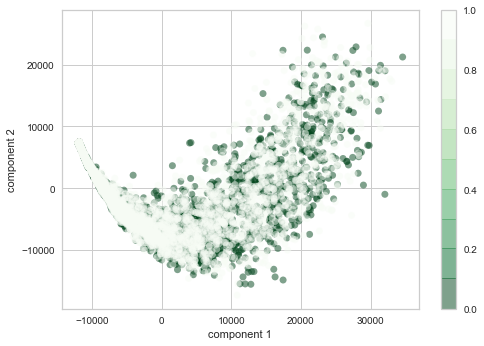

In [45]:
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
predicted_prob = clf.predict_proba(X_test)
predicted_prob = np.asarray([x[1] for x in predicted_prob])
acc = accuracy_score(y_test, predicted)
auc = roc_auc_score(y_test, predicted_prob)
f1 = f1_score(y_test, predicted)
print("MultinomialNB Accuracy:", acc)
print("MultinomialNB AUC Score:", auc)
print("MultinomialNB F1 Score:", f1)

# PCA plot for classification results
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(X_test)

plt.clf()
plt.scatter(projected[:, 0], projected[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Greens_r', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
plt.show()

### 2) Bag of Words

MultinomialNB Accuracy: 0.7751163191452697
MultinomialNB AUC Score: 0.8774769048478532
MultinomialNB F1 Score: 0.8023026814119073


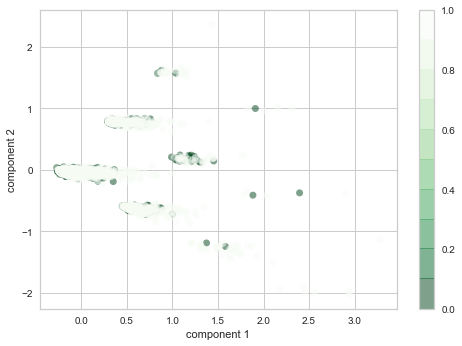

In [46]:
tokens = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(lowercase=True,stop_words='english',ngram_range = (1,1),tokenizer = tokens.tokenize,max_features=max_review_length)
cv.fit(df['Token_str'])

X_train_bow = cv.transform(df_train['Token_str'])
X_test_bow = cv.transform(df_test['Token_str'])
y_train = df_train['y'].values
y_test = df_test['y'].values

clf_bow = MultinomialNB().fit(X_train_bow, y_train)
predicted_bow= clf_bow.predict(X_test_bow)
predicted_bow_prob = clf_bow.predict_proba(X_test_bow)
predicted_bow_prob = np.asarray([x[1] for x in predicted_bow_prob])
acc_bow = accuracy_score(y_test, predicted_bow)
auc_bow = roc_auc_score(y_test, predicted_bow_prob)
f1_bow = f1_score(y_test, predicted_bow)
print("MultinomialNB Accuracy:", acc_bow)
print("MultinomialNB AUC Score:", auc_bow)
print("MultinomialNB F1 Score:", f1_bow)

# PCA plot for classification results
pca = PCA(2)  # project from 64 to 2 dimensions
projected_bow = pca.fit_transform(X_test_bow.todense())

plt.clf()
plt.scatter(projected_bow[:, 0], projected_bow[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Greens_r', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
plt.show()

### TFiDF

MultinomialNB Accuracy: 0.7711528519731173
MultinomialNB AUC Score: 0.8760928147482769
MultinomialNB F1 Score: 0.8047633049103206


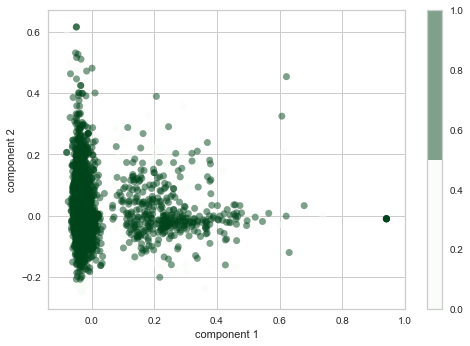

In [47]:
# encoder by tfidf
tf=TfidfVectorizer(max_features=max_review_length)
tf.fit(df['Token_str'])
X_train_tf = tf.transform(df_train['Token_str'])
X_test_tf = tf.transform(df_test['Token_str'])

# Model Generation Using Multinomial Naive Bayes
clf_tf = MultinomialNB().fit(X_train_tf, y_train)
predicted_tf= clf_tf.predict(X_test_tf)
predicted_tf_prob = clf_tf.predict_proba(X_test_tf)
predicted_tf_prob = np.asarray([x[1] for x in predicted_tf_prob])
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted_tf))
print("MultinomialNB AUC Score:",metrics.roc_auc_score(y_test, predicted_tf_prob))
print("MultinomialNB F1 Score:",metrics.f1_score(y_test, predicted_tf))

pca = PCA(2)  # project from 64 to 2 dimensions
projected_tf = pca.fit_transform(X_test_tf.todense())

plt.clf()
plt.scatter(projected_tf[:, 0], projected_tf[:, 1],
            c=y_test, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Greens', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();
plt.show()

# 2. Structural LSTM

This section concentrates on a neural network approaches based on LSTM. 

The LSTM layer in Model 1 is structured as the bidirectional LSTM which is the extension of the traditional LSTM. It can enhance the model performance on the sequence classification problems. This structure involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side proving the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second.

In Model 2, a one-dimensional CNN and max pooling layers can be easily added after the Embedding layer which then feeds the consolidated features to the LSTM. 

For these two methods, only Label Encoder method is applied to word encoding due to time limitation but their results look good.

For some preparation works beforehand, an early stopping function is defined which monitors the validation loss with patience 2.

In [12]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='loss', value=0.01, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            print("Early stopping requires %s available!" % self.monitor)
            exit()

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True
earlyStopping=EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='auto')

Model 1 contains an embedding layer and the bidirectional LSTM layer with regularization. The number of epoch is 10 and batch size is 64. The earlystopping is also applied

In [27]:
model_1 = Sequential()
model_1.add(Embedding(vocab_size, embedding_vector_length, input_length=max_review_length))
model_1.add(Bidirectional(LSTM(100, W_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01))))
model_1.add(Dense(1, activation='sigmoid'))
model_1.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
start_1 = time.time()
history_1 = model_1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64, callbacks=[earlyStopping])
end_1 = time.time()

/Users/qinchengwei/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, activity_regularizer=<keras.reg..., kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 23214 samples, validate on 5803 samples
Epoch 1/10
23214/23214 [==============================] - 342s 15ms/step - loss: 1.4558 - acc: 0.5597 - val_loss: 1.1247 - val_acc: 0.7201
Epoch 2/10
23214/23214 [==============================] - 524s 23ms/step - loss: 0.9213 - acc: 0.7962 - val_loss: 0.7691 - val_acc: 0.8123
Epoch 3/10
23214/23214 [==============================] - 425s 18ms/step - loss: 0.6774 - acc: 0.8580 - val_loss: 0.6214 - val_acc: 0.8318
Epoch 4/10
23214/23214 [==============================] - 373s 16ms/step - loss: 0.5705 - acc: 0.8809 - val_loss: 0.5557 - val_acc: 0.8632
Epoch 5/10
23214/23214 [==============================] - 386s 17ms/step - loss: 0.5179 - acc: 0.8936 - val_loss: 0.5226 - val_acc: 0.8639
Epoch 6/10
23214/23214 [==============================] - 403s 17ms/step - loss: 0.4854 - acc: 0.9026 - val_loss: 0.5032 - val_acc: 0.8544
Epoch 7/10
23214/23214 [==============================] - 387s 17ms/step - loss: 0.4612 - acc: 0.9054 - val_loss: 0.4

The figure of training loss vs validation loss shows the convergence of the model.

The training time for this model is over an hour.

In [32]:
f'{(end_1-start_1)/60} min'

'66.76109233697255 min'

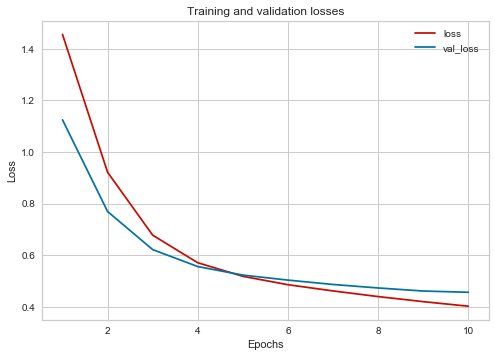

In [28]:
plt.clf()
history_dict = history_1.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1,len(loss)+1)
fig = plt.figure()
plt.title('Training and validation losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs,loss,'r',label='loss')
plt.plot(epochs,val_loss,'b',label='val_loss')
plt.legend()
plt.show()

In [29]:
y_test_pred = model_1.predict(X_test)
y_test_class = model_1.predict_classes(X_test)
print("LSTM Accuracy:", accuracy_score(y_test,y_test_class))
print("LSTM AUC Score:", roc_auc_score(y_test,y_test_pred))
print("LSTM F1 Score:", f1_score(y_test,y_test_class))

LSTM Accuracy: 0.8524900913320697
LSTM AUC Score: 0.9477366571004026
LSTM F1 Score: 0.8760856977417487


Comparing to Model 1, there are two more layers including convolution and maxpooling in Model 2 which decrease the complexity of model so that the model training time is shorter than Model 1.

In [21]:
model_2 = Sequential()
model_2.add(Embedding(vocab_size, embedding_vector_length, input_length=max_review_length))
model_2.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model_2.add(MaxPooling1D(pool_size=2))
model_2.add(Bidirectional(LSTM(100, W_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(0.01))))
model_2.add(Dense(1, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
start_2 = time.time()
history_2 = model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64, callbacks=[earlyStopping])
end_2 = time.time()

/Users/qinchengwei/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, activity_regularizer=<keras.reg..., kernel_regularizer=<keras.reg...)`
  """


Train on 23214 samples, validate on 5803 samples
Epoch 1/10
23214/23214 [==============================] - 211s 9ms/step - loss: 1.4483 - acc: 0.5488 - val_loss: 1.1269 - val_acc: 0.5504
Epoch 2/10
23214/23214 [==============================] - 197s 8ms/step - loss: 0.9148 - acc: 0.7862 - val_loss: 0.7562 - val_acc: 0.8478
Epoch 3/10
23214/23214 [==============================] - 212s 9ms/step - loss: 0.6614 - acc: 0.8754 - val_loss: 0.6041 - val_acc: 0.8609
Epoch 4/10
23214/23214 [==============================] - 200s 9ms/step - loss: 0.5502 - acc: 0.8956 - val_loss: 0.5389 - val_acc: 0.8651
Epoch 5/10
23214/23214 [==============================] - 198s 9ms/step - loss: 0.4953 - acc: 0.9070 - val_loss: 0.5068 - val_acc: 0.8658
Epoch 6/10
23214/23214 [==============================] - 197s 8ms/step - loss: 0.4608 - acc: 0.9160 - val_loss: 0.4870 - val_acc: 0.8664
Epoch 7/10
23214/23214 [==============================] - 212s 9ms/step - loss: 0.4344 - acc: 0.9223 - val_loss: 0.4726 - v

The training time is much shorter than BiLSTM

In [26]:
f'{(end_2-start_2)/60} min'

'33.2519492983818 min'

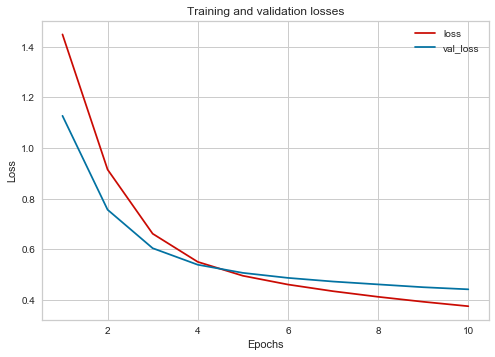

In [22]:
plt.clf()
history_dict = history_2.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1,len(loss)+1)
fig = plt.figure()
plt.title('Training and validation losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs,loss,'r',label='loss')
plt.plot(epochs,val_loss,'b',label='val_loss')
plt.legend()
plt.show()

In [24]:
y_test_pred = model_2.predict(X_test)
y_test_class = model_2.predict_classes(X_test)
print("LSTM Accuracy:", accuracy_score(y_test,y_test_class))
print("LSTM AUC Score:", roc_auc_score(y_test,y_test_pred))
print("LSTM F1 Score:", f1_score(y_test,y_test_class))

LSTM Accuracy: 0.8623125969326211
LSTM AUC Score: 0.9452403538838113
LSTM F1 Score: 0.8778847623414336


Save models

In [53]:
model_json = model_1.to_json()
with open("./models/model_1.json", "w") as json_file:
    json_file.write(model_json)
model_1.save_weights("./models/model_1.h5")

In [54]:
model_json = model_2.to_json()
with open("./models/model_2.json", "w") as json_file:
    json_file.write(model_json)
model_2.save_weights("./models/model_2.h5")